In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from deep_convnet import DeepConvNet
%matplotlib inline

from common.functions import softmax

Using TensorFlow backend.


In [2]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = mnist.load_data()

In [3]:
eps = 0.3

In [4]:
n = 10

In [5]:
def generate_stack_list(x_list, t_list, max_n):
    stack_x_list = []
    stack_i_list = []
    for _ in range(10):
        stack_x_list.append([])
        stack_i_list.append([])
        
    fill_list = []
    for i, t in enumerate(t_list):
        if (not t in fill_list) and len(stack_x_list[t]) < max_n:
            stack_x_list[t].append(x_list[i].flatten())
            stack_i_list[t].append(i)
        else:
            fill_list.append(t)
            
    return np.array(stack_x_list), np.array(stack_i_list)

In [6]:
def generate_avg_list(stack_x_list):            
    avg_list = []
    for stacks in stack_x_list:
        avg = np.mean(stacks, axis=0)
        avg_list.append(avg.reshape(28,28))
        
    return np.array(avg_list)

In [7]:
stack_x_list, stack_i_list = generate_stack_list(x_test, t_test, n) 

# 平均化
avg_test = generate_avg_list(stack_x_list)

# 正規化
x_test = x_test.astype(np.float32) / 255.0
avg_test = avg_test.astype(np.float32) / 255.0

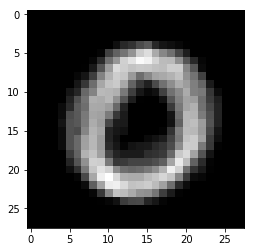

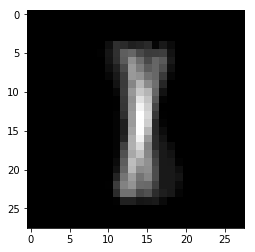

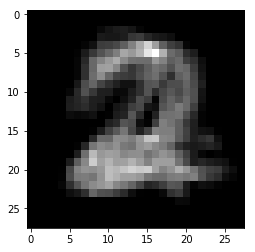

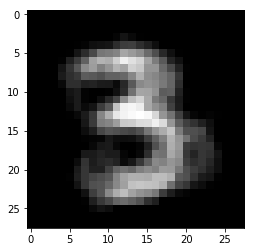

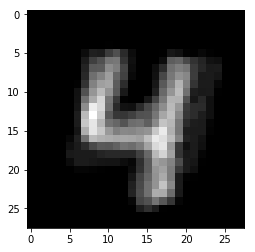

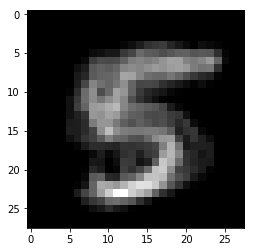

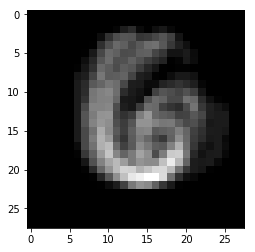

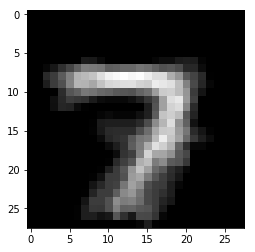

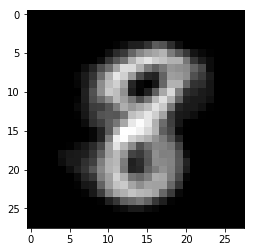

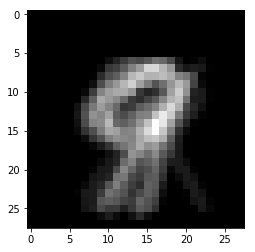

In [8]:
for avg in avg_test:
    plt.imshow(avg, 'gray')
    plt.show()

In [9]:
network = DeepConvNet()

network.load_params("deep_convnet_params.pkl")
print("loaded Network Parameters!")

loaded Network Parameters!


In [10]:
def show_generate_adv(x, label, network, eps=0.01):
    x = x.reshape(1, 1, 28, 28)
    
    pre = network.predict(x)
    pre_label = np.argmax(pre)
    pre_score = round(max(softmax(pre[0])), 2)
    
    fig = plt.figure(figsize=(20, 20))
    fig.subplots_adjust(wspace=0.4, hspace=0.1)
    ax = fig.add_subplot(1, 3, 1)
    ax.set_title(f"{pre_label} : {pre_score}")
    ax.imshow(x.reshape(28,28), 'gray')
    
    d, g = network.gradient_for_fgsm(x, np.array([label]))
    d = d.reshape(28, 28)
    p = eps * np.sign(d)
    
    pre = network.predict(p.reshape(1, 1, 28, 28))
    pre_label = np.argmax(pre)
    pre_score = round(max(softmax(pre[0])), 2)
    
    ax = fig.add_subplot(1, 3, 2)
    ax.set_title(f"{pre_label} : {pre_score}")
    ax.imshow(p, 'gray')
    
    adv = (x + p).clip(min=0, max=1)
    adv = adv.reshape(1, 1, 28, 28)
    
    pre = network.predict(adv)
    pre_label = np.argmax(pre)
    pre_score = round(max(softmax(pre[0])), 2)
    
    ax = fig.add_subplot(1, 3, 3)
    ax.set_title(f"{pre_label} : {pre_score}")
    ax.imshow(adv.reshape(28,28), 'gray')
    
    return adv

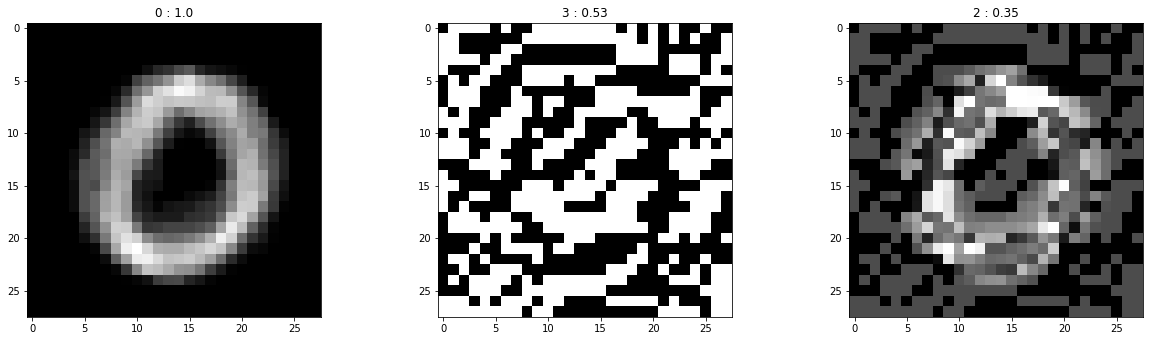

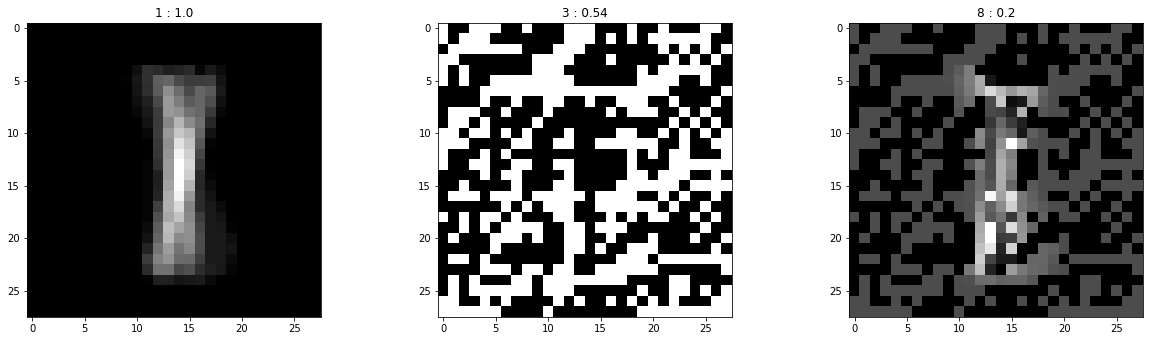

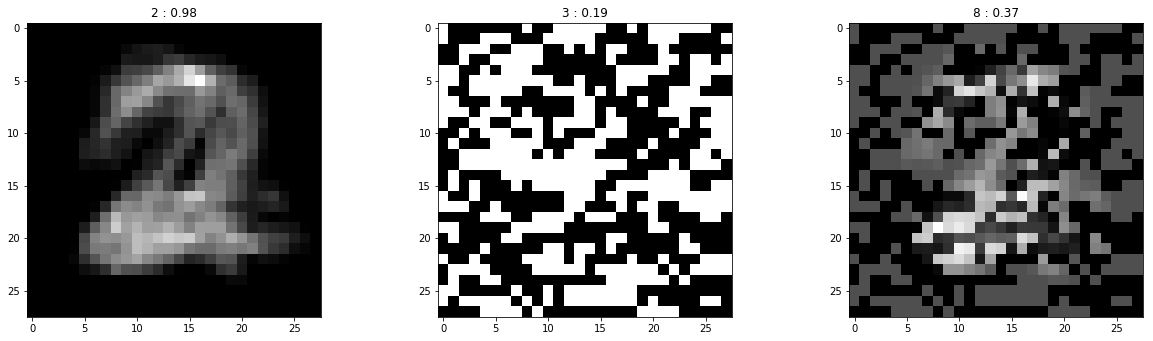

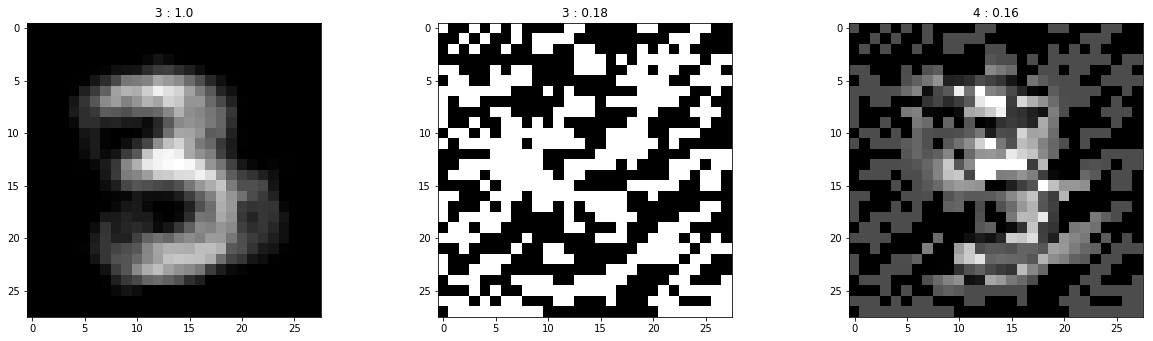

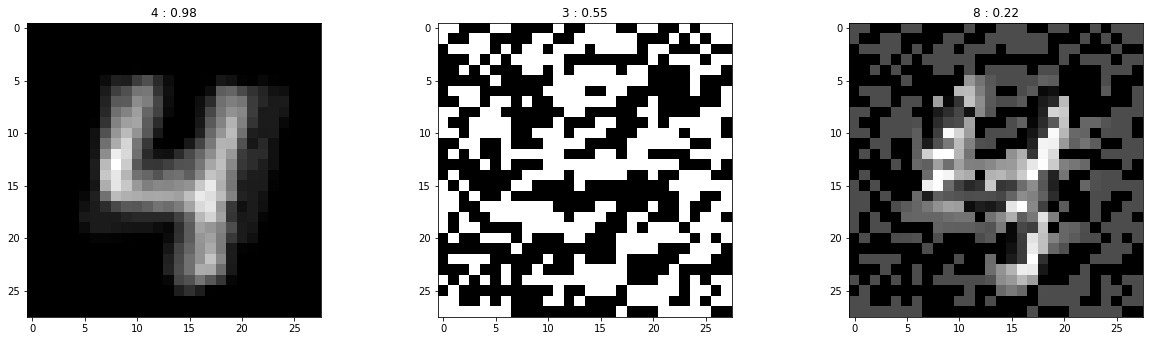

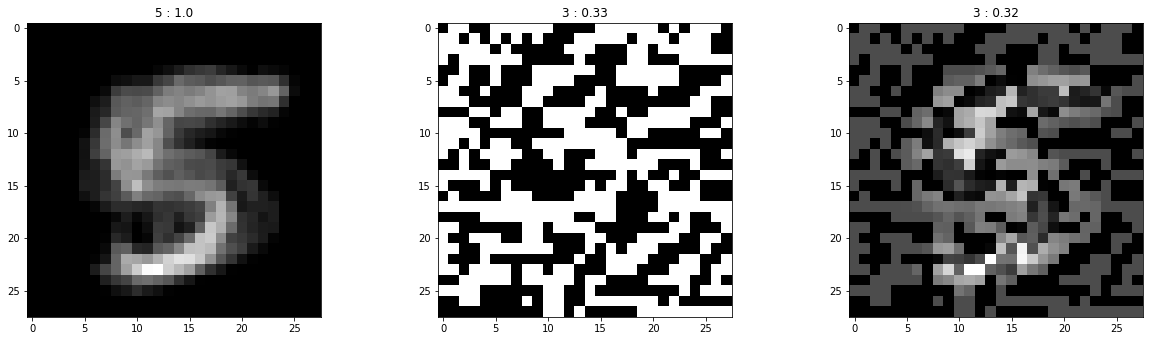

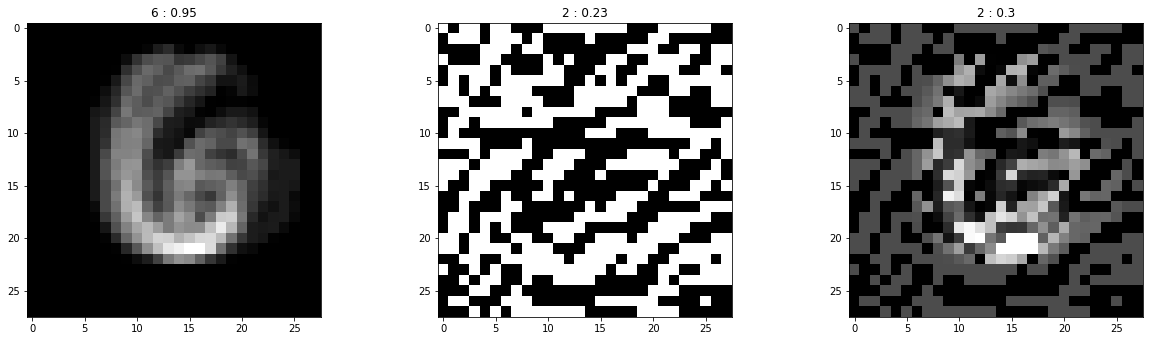

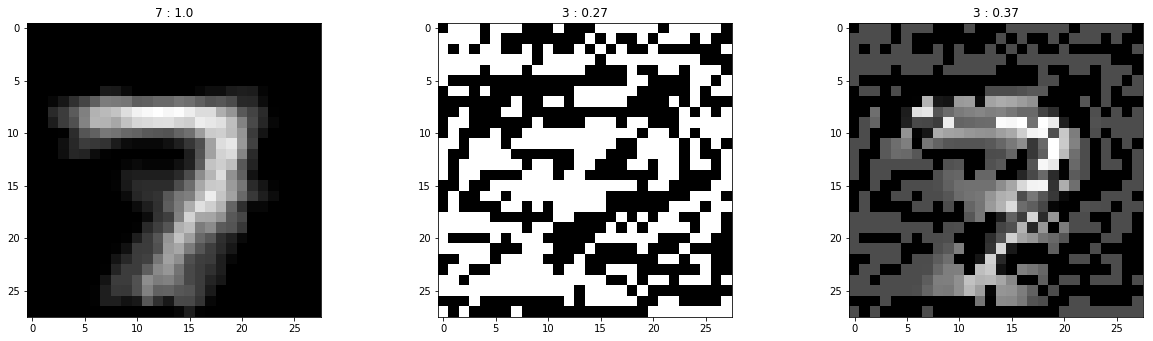

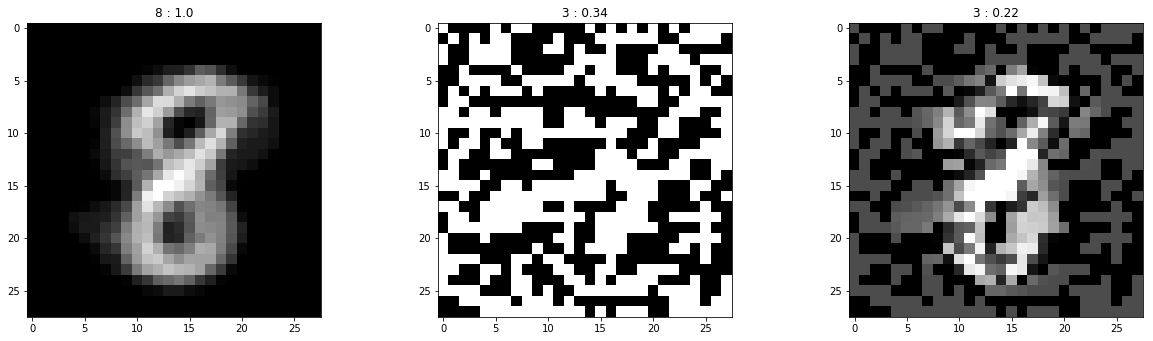

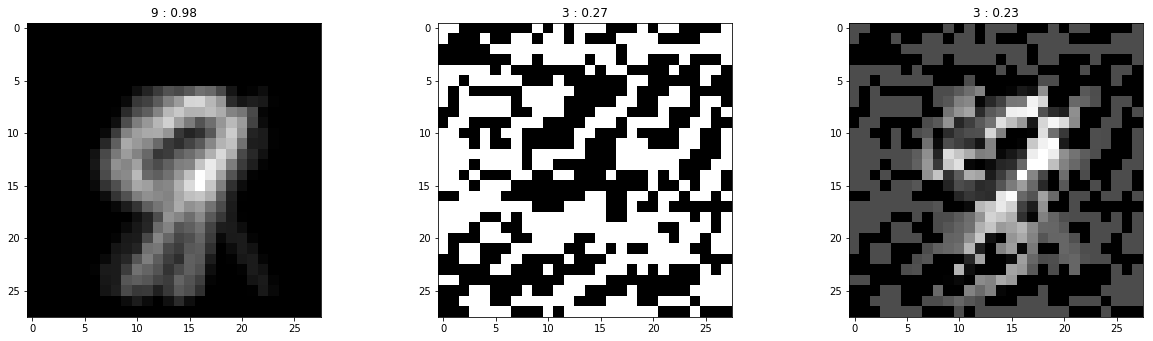

In [11]:
for i, avg in enumerate(avg_test):
    adv = show_generate_adv(avg, i, network, eps)

In [12]:
def generate_setsudo(x, label, network, eps):
    x = x.reshape(1, 1, 28, 28)
    
    d, g = network.gradient_for_fgsm(x, np.array([label]))
    d = d.reshape(28, 28)
    p = eps * np.sign(d)
    
#     plt.imshow(p, 'gray')
#     plt.show()
    
    return p

In [13]:
def generate_setsudo_list(avg_list, network, eps):
    setsudo_list = []
    for i, avg in enumerate(avg_list):
        setsudo = generate_setsudo(avg, i, network, eps)
        setsudo_list.append(setsudo)

    return np.array(setsudo_list)

In [14]:
setsudo_list = generate_setsudo_list(avg_test, network, eps)
setsudo_list.shape

(10, 28, 28)

In [15]:
avg_adv_list = []
for i, (idxs, s) in enumerate(zip(stack_i_list, setsudo_list)):
    buf_list = []
    for idx in idxs:
        x = x_test[idx].reshape(1,1,28,28)
        adv = (x+s).clip(min=0, max=1)
        buf_list.append(adv.reshape(1, 28, 28))
        
    avg_adv_list.append(buf_list)
    
avg_adv_list = np.array(avg_adv_list)

In [19]:
for i, li in enumerate(avg_adv_list):
    print(i)
    miss = 0
    for a in li:
        pre = network.predict(a.reshape(1,1,28,28))
        pre_label = np.argmax(pre)
        pre_score = round(max(softmax(pre[0])), 2)
#         plt.imshow(a.reshape(28,28), 'gray')
#         plt.title(f"{pre_label} : {pre_score}")
#         plt.show()
        
        if pre_label != i:
            miss += 1
            
    print(miss/n)
    print("-----")

0
0.3
-----
1
1.0
-----
2
0.1
-----
3
0.1
-----
4
0.4
-----
5
0.1
-----
6
0.2
-----
7
0.3
-----
8
0.2
-----
9
0.5
-----
